# Import the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [3]:
# Load the IMDB dataset
max_features = 10000 # use top 10,000 words
maxlen = 100 # Cut texts after this number of words

# Load the data and labels
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

# Pad sequences to ensure consistent input size
x_train = pad_sequences(x_train, maxlen = maxlen)
x_test = pad_sequences(x_test, maxlen = maxlen)

In [5]:
x_train.shape

(25000, 100)

# Create the transformer block

In [9]:
# Transformer block defination

def transformer_block(inputs, num_heads, ff_dim, dropout_rate):
    # Multi-head Attention Layer
    attention_output = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = ff_dim)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    # Feed-forward Network
    ffn_output = layers.Dense(ff_dim, activation='relu')(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    output = layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return output

# Complete the model

In [11]:
# Define the full model

def create_transformer_model(input_shape, num_heads = 2, ff_dim = 64, dropout_rate = 0.1):
    inputs = layers.Input(shape = input_shape)

    # Embeding layer
    x = layers.Embedding(input_dim = max_features, output_dim = ff_dim)(inputs)

    # Apply transformer block
    x = transformer_block(
        x, num_heads = num_heads, ff_dim = ff_dim, dropout_rate = dropout_rate)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layer for binary classification
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)

    # Create and compile the model
    model = models.Model(inputs = inputs, outputs = x)
    model.compile(optimizer= Adam(learning_rate=1e-4),
                  loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

# Create the model
model = create_transformer_model(input_shape = (maxlen,))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 100, 64)        │        640,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 100, 64)        │         33,216 │ embedding_3[0][0],     │
│ (MultiHeadAttention)      │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 100, 64)        │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 100, 64)        │              0 │ dropout_11[0][0],      │
│                           │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 100, 64)        │            128 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 100, 64)        │          4,160 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 100, 64)        │          4,160 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 100, 64)        │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 100, 64)        │              0 │ layer_normalization_4… │
│                           │                        │                │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 100, 64)        │            128 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ layer_normalization_5… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 686,017 (2.62 MB)

 Trainable params: 686,017 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.utils import plot_model

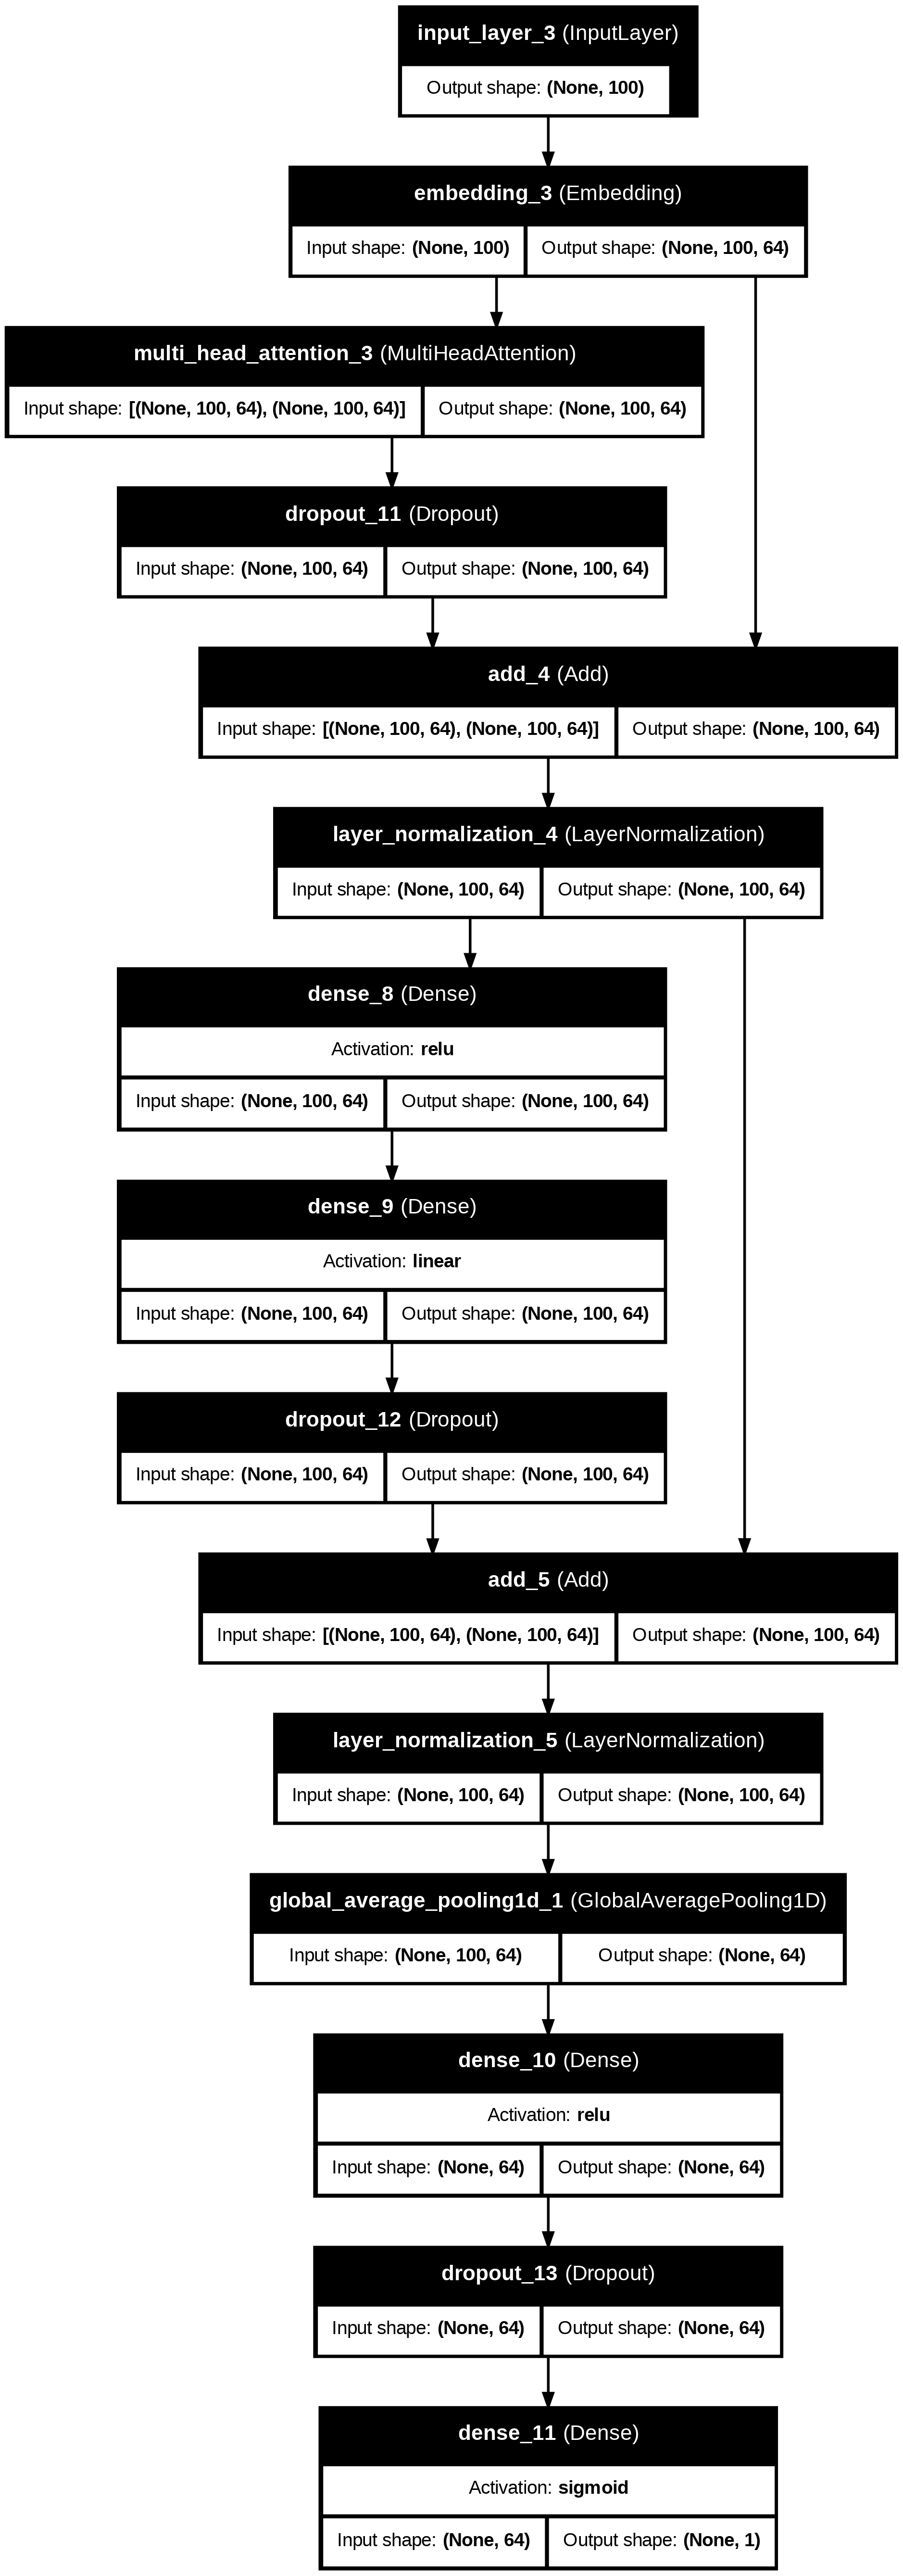

In [13]:
plot_model(model, show_layer_activations=True, show_layer_names = True, show_shapes=True)

# Train the model

In [14]:
history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - accuracy: 0.6543 - loss: 0.6027 - val_accuracy: 0.8317 - val_loss: 0.3699
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.8765 - loss: 0.2989 - val_accuracy: 0.8379 - val_loss: 0.3629
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.9055 - loss: 0.2434 - val_accuracy: 0.8438 - val_loss: 0.3653
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.9251 - loss: 0.2017 - val_accuracy: 0.8278 - val_loss: 0.4130
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 110ms/step - accuracy: 0.9400 - loss: 0.1729 - val_accuracy: 0.8396 - val_loss: 0.4040
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 166s 140ms/step - accuracy: 0.9471 - loss: 0.1556 - val_accuracy: 0.8346 - val_loss: 0.4538
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 101ms/step - accuracy: 0.9489 - loss: 0.1507 - val_accuracy: 0.8254 - val_loss: 0.4804
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 97ms/step - accuracy: 0.9601 - loss: 0

In [19]:
# Evaluate the model lon the test set
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size = 1)
print(f'Test accuracy: {test_acc}')

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.8246 - loss: 0.6008
Test accuracy: 0.8241199851036072


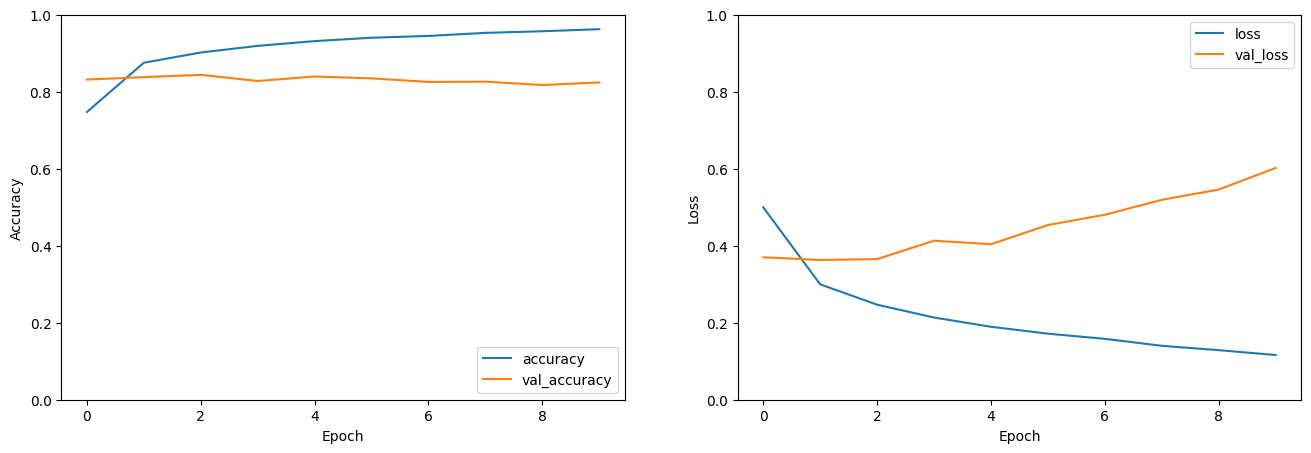

In [15]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy

plt.figure(figsize = (16, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'upper right')